In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint as pp
import seaborn as sns

Okay, let's load the database file. It should be in the format (url, {ingred:[...], other data})

In [3]:
with open("database_py3.pkl", "rb") as fh:
    data = pickle.load(fh)
    
type(data)
print(len(data))
pp.pprint(data[list(data.keys())[0]])
pp.pprint(list(data.keys())[0])

37625
{'ingred': ['kosher salt',
            'garam masala',
            'cumin',
            'black pepper',
            'sweet potatoes',
            'olive oil',
            'cinnamon sticks',
            'cloves',
            'cardamom seeds',
            'black cardamom pods'],
 'pic_URL': 'http://foodnetwork.sndimg.com/content/dam/images/food/fullset/2012/3/30/0/0182341_sweet-potato-fries_s4x3.jpg.rend.sni12col.landscape.jpeg',
 'prep_time': 45,
 'rating': (4.8, 8),
 'recipe_rank': 17596,
 'title': 'Sweet Potato Fries'}
'http://www.foodnetwork.com/recipes/aarti-sequeira/sweet-potato-fries-recipe.html'


It looks good. Now let's verify that we have clean ingredients in the dict. I'm expecting about 2500. If there are significantly more, than we do not have a clean database

In [4]:
ingr_set = set()
for key, val in data.items():
    for i in val['ingred']:
        if i == ' ':
            data[key]['ingred'].remove(i)
        ingr_set.add(i)
        
print(len(ingr_set))
print(list(ingr_set)[:5])

2469
['butter oil', 'pancake mix', 'pears', 'mini pepperoni slices', 'acorn squash']


Jackpot! Now I want to build a dataset containing all ingredients and their weight in the format ing1:ing2:number of connections

First let's build a matrix

In [5]:
ingr = sorted(list(ingr_set))[1:] # The first element will be ' '
print(ingr[:5])
matrix = pd.DataFrame(data=(np.zeros((len(ingr), len(ingr)))), index=ingr, columns=ingr)
print(matrix.shape)

bigdict = {}
for i in ingr:
    bigdict[i] = {}
    for j in ingr:
        bigdict[i][j] = 0

['1% low-fat milk', '2% lowfat greek yogurt', '2% reduced-fat milk', '60% cacao bittersweet chocolate', 'acacia honey']
(2468, 2468)


Now it's time to populate it. I should write this better, but I'm lazy.

In [6]:
for _, value in data.items():
    for ing1 in value['ingred']:
        for ing2 in value['ingred']:
            if ing1 != ing2:
                bigdict[ing1][ing2] += 1

In [7]:
for key1, dct in bigdict.items():
    for key2, count in dct.items():
        matrix.set_value(key1, key2, count)

Now let's look at how many nonzero rows there are. A higher number would correspond with a more versatile food --that is a food that can be combined with many others.

In [8]:
print(sum(matrix.astype(bool).sum())/2 - 2468) # Total number of combinations of ingredients
counts = matrix.astype(bool).sum(axis=1)
counts.sort_values(inplace=True)
print(counts[:10])
print(counts[-10:])

287043.0
miniature peanut butter cups    1
apple puree                     2
almond chocolate milk           2
freeze-dried raspberries        2
chocolate eggs                  3
oatmeal cookie mix              3
stew                            3
southern comfort                3
whole grain brown rice          3
coleslaw dressing               3
dtype: int64
olive oil       1855
mangoes         1872
garlic          1881
sugar           1899
black pepper    1919
eggs            1926
kosher salt     1936
water           1960
butter          2075
salt            2169
dtype: int64


Why are there so many recipes with mangoes?

In [9]:
matrix.mangoes

1% low-fat milk                     13.0
2% lowfat greek yogurt               0.0
2% reduced-fat milk                  1.0
60% cacao bittersweet chocolate      0.0
acacia honey                         2.0
accent seasoning                     0.0
achiote powder                       0.0
acorn squash                         1.0
active dry yeast                    30.0
adobo                               75.0
adobo all purpose seasoning          0.0
adobo seasoning                      3.0
agar                                 4.0
agave in the raw®                   17.0
agave nectar                        13.0
agave tequila                        2.0
ahi                                  1.0
aioli                               11.0
ajinomoto                            0.0
albacore tuna in water               0.0
alcohol                             10.0
aleppo pepper                        0.0
alfalfa sprouts                      2.0
alfredo sauce                        1.0
alfredo sauce mi

Right, well I don't believe that for a second. But maybe it's just that recipes that have mangoes have so many ingredients that at some point it's matched with everything. Let's try it this way...

In [10]:
mango_count = 0
for _, value in data.items():
    for i in value['ingred']:
        if i == 'mangoes':
            mango_count += 1
print(mango_count)
print(mango_count/len(data))

5249
0.13950830564784053


Huh, So mangoes are in ~14% of all recipes? While I don't know that I necessarily believe that, it is plausible. One interesting thing is that mangoes seem to appear with almost every other ingredient making mangoes an incredibly versatile food.

Let's move on and do a quick export to a csv so we can play in R some as well.

In [11]:
matrix.to_csv("matrix.csv")

We now have a matrix with ~3M entries, ~287k are non-empty (not counting duplicates). Let's try to get rid of some data so we can create a manageable viz. Let's say I want 400 lines, that would be 20x20, so there is some serious whiddling down to do. I'm going to start by doing 20 ingredients randomly.

In [12]:
plottable = None
plottable = matrix.sample(n=100)
#plottable.index
plottable = plottable[plottable.index]
plottable = plottable.where(np.triu(np.ones(plottable.shape)).astype(np.bool))

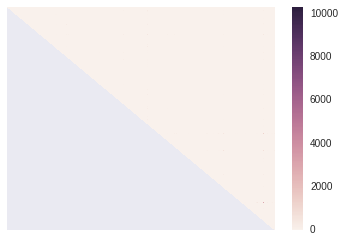

In [13]:
%matplotlib inline
sns.heatmap(matrix.where(np.triu(np.ones(matrix.shape)).astype(np.bool)), xticklabels=False, yticklabels=False)

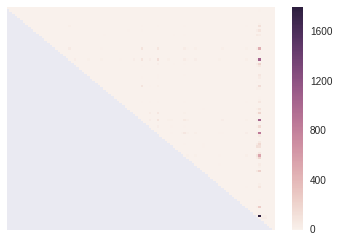

In [14]:
%matplotlib inline
sns.heatmap(plottable, xticklabels=False, yticklabels=False)

Okay, well sparse doesn't necessarily mean bad. Let's explore the distribution of counts. If there are a lot of very weak connections, we could probably toss them, as well as ingredients that have very very low overall counts. That may reduce our dimensionality some. Again, currently ~287k datapoints (connections), which is more than I would like to display to a user.

[0.0, 0.0, 0.0, 0.0, 0.0]
[8383.0, 8456.0, 9322.0, 9322.0, 10292.0]
3046746


/home/rich/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


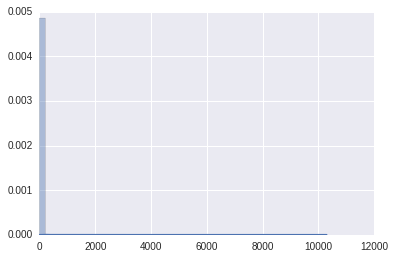

In [15]:
%matplotlib inline
tri_matrix = matrix.where(np.triu(np.ones(matrix.shape)).astype(np.bool))
av = []
for idx, series in tri_matrix.iterrows():
    for j in series:
        if not np.isnan(j):
            av.append(j)
av = sorted(av)
print(av[:5])
print(av[-5:])
print(len(av))

sns.distplot(av)

1962
201.0


/home/rich/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


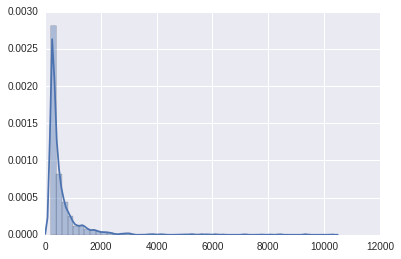

In [18]:
%matplotlib inline
if(av[0] < av[-1]):
    av.reverse()
nonzero = av[:av.index(200.0)] # originally just nonzero, but I bumped it up to 
                               # reduce the size of the data in anticipation of plotting
print(len(nonzero))
print(nonzero[-1])
sns.distplot(nonzero)

Well we can see we have a very zipfian distribution of ingredients that occur together. Most ingredients interact very few times, but there are some (the long tail) that are incredibly common.

# Build the dataset for plotting

In [19]:
min = 800.0
datapoints = 0
allkeys = set()
plotdata = {}
for row in tri_matrix.index:    
    for col in tri_matrix.index:
        if tri_matrix.get_value(row, col) > min:
            if row not in plotdata:
                plotdata[row] = {}
            plotdata[row][col] = tri_matrix.get_value(row, col)
            datapoints += 1
            allkeys.add(row)
            allkeys.add(col)
print(datapoints)
print(len(allkeys))

360
77


In [71]:
pp.pprint(plotdata)

{'active dry yeast': {'olive oil': 274.0, 'water': 252.0},
 'all-purpose flour': {'bacon': 303.0,
                       'baking powder': 1847.0,
                       'baking soda': 1242.0,
                       'bay leaves': 398.0,
                       'beaten eggs': 428.0,
                       'black pepper': 2213.0,
                       'bread crumbs': 258.0,
                       'brown sugar': 390.0,
                       'butter': 6065.0,
                       'buttermilk': 786.0,
                       'canola oil': 510.0,
                       'carrots': 433.0,
                       'cayenne pepper': 624.0,
                       'celery': 532.0,
                       'chicken broth': 359.0,
                       'chicken stock': 434.0,
                       'cinnamon': 1163.0,
                       'confectioners sugar': 833.0,
                       'cooking spray': 550.0,
                       'corn starch': 326.0,
                       'cream cheese': 43

In [20]:
strings = ['[']
for ing1, subdict in plotdata.items():
    for ing2, value in subdict.items():
        strings.append('{"name": "' + ing1 + '", "size": ' + str(value) + ', "imports":["' + ing2 + '"]},\n')
strings[-1] = strings[-1][:-2] # remove final comma and newline
strings.append(']')

with open("data.json", "w") as fh:
    fh.writelines(strings)
